# Analyzing 'sit-lie' arrests by LAPD: 2010-19

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read in arrests data from city portal

In [2]:
# https://data.lacity.org/api/views/yru6-6re4/rows.csv?accessType=DOWNLOAD
arrests = pd.read_csv('/Users/mhustiles/data/data/LA/Arrest_Data_from_2010_to_Present.csv')

### How many arrest cases are in the database?

In [3]:
len(arrests)

1328349

### Clean up arrests DataFrame

In [4]:
arrests.columns = arrests.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
arrests['arrest_date'] = pd.to_datetime(arrests['arrest_date'], format='%m/%d/%Y')
arrests['year'] = arrests['arrest_date'].dt.year
arrests['quarter'] = arrests['arrest_date'].dt.quarter
arrests['day'] = arrests['arrest_date'].dt.day
arrests['month'] = arrests['arrest_date'].dt.month
arrests['monthname'] = arrests['arrest_date'].dt.month_name()
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month', 'day']] = \
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month','day']].astype(str)
arrests['charge_group_code'] = arrests['charge_group_code'].str.replace('.0', '', regex=False)
arrests['weekday'] = arrests['arrest_date'].dt.weekday_name
arrests['time'] = arrests['time'].str.replace('.0','', regex=False)
arrests['time'] = arrests['time'].str.zfill(4)
arrests['hour'] = arrests['time'].str[:2]
arrests['minute'] = arrests['time'].str[2:]
arrests = arrests[arrests['hour'] != '0n']
arrests = arrests[arrests['hour'] != '24']
arrests.drop('cross_street', axis=1, inplace=True)

In [5]:
arrests = arrests[arrests['arrest_date'] < '1/1/2020']

In [6]:
arrests.head().sort_values(by='arrest_date', ascending=False)

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,quarter,day,month,monthname,weekday,hour,minute
2,5806609,2019-11-23,1830,4,Hollenbeck,457,23,F,H,3,Robbery,F,211PC,ROBBERY,FICKETT,"(34.0477, -118.2047)",2019,4,23,11,November,Saturday,18,30
0,191811472,2019-05-03,1700,18,Southeast,1802,23,F,B,nan,NaN,M,653.22 PC,NaN,91ST,"(33.9543, -118.2827)",2019,2,3,5,May,Friday,17,00
3,5615197,2019-04-30,0615,6,Hollywood,663,27,M,O,5,Burglary,F,459PC,BURGLARY,LA BREA,"(34.0907, -118.3384)",2019,2,30,4,April,Tuesday,06,15
4,5615701,2019-04-30,1100,9,Van Nuys,901,2,F,H,nan,NaN,D,300(B)WIC,NaN,RAYMER,"(34.2149, -118.4674)",2019,2,30,4,April,Tuesday,11,00
1,5614161,2019-04-29,1040,8,West LA,842,41,M,H,3,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,"(34.0508, -118.4592)",2019,2,29,4,April,Monday,10,40


In [7]:
arrests.columns

Index(['report_id', 'arrest_date', 'time', 'area_id', 'area_name',
       'reporting_district', 'age', 'sex_code', 'descent_code',
       'charge_group_code', 'charge_group_description', 'arrest_type_code',
       'charge', 'charge_description', 'address', 'location', 'year',
       'quarter', 'day', 'month', 'monthname', 'weekday', 'hour', 'minute'],
      dtype='object')

### Highlight nighttime hours

In [8]:
night = ['01', '02', '03', '04', '05', '21', '22', '23', '00']
arrests['night'] = arrests['hour'].isin(night)
night_arrests = arrests[arrests['hour'].isin(night)]

In [9]:
(arrests['night'].value_counts('normalize')*100).round(2)

False    68.59
True     31.41
Name: night, dtype: float64

In [10]:
day_night_years = arrests.groupby(['night', 'year']).agg('size').reset_index(name='total')

In [11]:
day_night_years_pivot = pd.pivot_table(day_night_years, values='total', index=['night'], columns=['year'],\
                        aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()

In [12]:
day_night_years_pivot.head()

year,night,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,False,111206,107623,112195,102864,93116,85258,81022,76351,73239,65678
1,True,51168,49983,51085,49764,46216,40840,37042,31211,30965,27697


### Separate location field into lat/lon

In [13]:
arrests['location'] = arrests.location.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in arrests['location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

arrests['latitude'] = lat
arrests['longitude'] = lon
arrests['latitude'] = arrests['latitude'].astype(float)
arrests['longitude'] = arrests['longitude'].astype(float)

### Recode descent names into something useful

In [14]:
descent_recode ={'A':"Asian",'B':"Black",'C':"Asian",'D':"Asian",'F':"Asian",'G':"Asian",'H':"Hispanic",'I':"American Indian/Alaskan Native",'J':"Asian",'K':"Asian",'L':"Asian",'O':"Other",'P':"Asian",'S':"Asian",'U':"Asian",'V':"Asian",'W':"White",'X':"Other",'Z':"Asian"}

In [15]:
arrests['descent_description'] = arrests['descent_code'].map(descent_recode)

In [16]:
arrest_type_recode ={'F':"Felony",'I':"Infraction",'M':"Misdemeanor",'O':"Other"}

In [17]:
arrests['arrest_type_description'] = arrests['arrest_type_code'].map(arrest_type_recode)

In [18]:
arrests.head()

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,quarter,day,month,monthname,weekday,hour,minute,night,latitude,longitude,descent_description,arrest_type_description
0,191811472,2019-05-03,1700,18,Southeast,1802,23,F,B,nan,NaN,M,653.22 PC,NaN,91ST,"33.9543, -118.2827",2019,2,3,5,May,Friday,17,00,False,33.9543,-118.2827,Black,Misdemeanor
1,5614161,2019-04-29,1040,8,West LA,842,41,M,H,3,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,"34.0508, -118.4592",2019,2,29,4,April,Monday,10,40,False,34.0508,-118.4592,Hispanic,Felony
2,5806609,2019-11-23,1830,4,Hollenbeck,457,23,F,H,3,Robbery,F,211PC,ROBBERY,FICKETT,"34.0477, -118.2047",2019,4,23,11,November,Saturday,18,30,False,34.0477,-118.2047,Hispanic,Felony
3,5615197,2019-04-30,0615,6,Hollywood,663,27,M,O,5,Burglary,F,459PC,BURGLARY,LA BREA,"34.0907, -118.3384",2019,2,30,4,April,Tuesday,06,15,False,34.0907,-118.3384,Other,Felony
4,5615701,2019-04-30,1100,9,Van Nuys,901,2,F,H,nan,NaN,D,300(B)WIC,NaN,RAYMER,"34.2149, -118.4674",2019,2,30,4,April,Tuesday,11,00,False,34.2149,-118.4674,Hispanic,NaN


### Count the arrests by charge type

In [19]:
charges_grouped = arrests.groupby(['charge', 'charge_description']).agg('size').sort_values(ascending=False).reset_index(name='total')

### Top 10 arrest citywide charges 2010-2019

In [20]:
charges_grouped[charges_grouped['charge_description'].str.contains('PARK')].head(10)

,charge,charge_description,total
7,25620BP,OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE,26061
106,63.44BLAMC,PARK REGULATIONS,2072
107,63.44B14LAM,PRESENT IN PARK AFTER HOURS,2043
110,63.44LAMC,PARK REGULATIONS,1971
212,243.2(A)1PC,BATTERY ON PERSON ON SCHOOL/HOSP/PARK/PROP,490
572,80.73LAMC,UNLAWFUL PARKING PEDDLERS/VENDORS,60
612,23103(B)VC,RECKLESS DRIVING IN PARKING LOT,51
637,25660BP,POSS OF OPEN CONTAINER OF ALCOHOL IN PARK,45
725,63.44B19LAM,LITTERING IN PARK,35
770,103.202BLAM,PARKING LOT W/O PERMIT,29


---

### Isolate all 'sit-lie' cases and just 41.18D

In [21]:
sit_lie_all = arrests[arrests.charge.str.contains('41.18')]
sit_lie_d = arrests[arrests['charge'] == '41.18DLAMC']
sidewalk_property_cases = arrests[arrests.charge.str.contains('56.11')]
parks = arrests[arrests.charge.str.contains('63.44')]


homeless_charges = arrests[(arrests.charge.str.contains('63.44')) |\
                          (arrests.charge.str.contains('56.11')) | \
                          (arrests.charge.str.contains('41.18'))]


### How many 'sit-lie' cases total?

In [22]:
len(sit_lie_all)

37112

### How many '41.18D' cases total?

In [23]:
len(sit_lie_d)

28727

### How many '63.44' cases? 

In [24]:
len(parks)

22596

### How many 'homeless' charge (parks, sit-lie, property) cases? 

In [25]:
len(homeless_charges)

63879

In [26]:
homeless_charges.sort_values(by='arrest_date', ascending=False).head()

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,quarter,day,month,monthname,weekday,hour,minute,night,latitude,longitude,descent_description,arrest_type_description
68414,201404437,2019-12-31,0800,14,Pacific,1411,19,M,W,nan,NaN,I,63.44I9LAMC,NaN,OCEAN FRONT WK,"33.9958, -118.4815",2019,4,31,12,December,Tuesday,08,00,False,33.9958,-118.4815,White,Infraction
67561,201404434,2019-12-31,0705,14,Pacific,1411,30,M,B,nan,NaN,I,63.44I9LAMC,NaN,OCEAN FRONT WK,"33.9947, -118.4805",2019,4,31,12,December,Tuesday,07,05,False,33.9947,-118.4805,Black,Infraction
67979,201404438,2019-12-31,0810,14,Pacific,1411,45,F,W,nan,NaN,I,63.44I9LAMC,NaN,NAVY,"33.9918, -118.4791",2019,4,31,12,December,Tuesday,08,10,False,33.9918,-118.4791,White,Infraction
66983,200104154,2019-12-30,1015,1,Central,148,49,M,O,nan,NaN,M,56.11.10LAM,NaN,5TH ST,"34.0417, -118.2398",2019,4,30,12,December,Monday,10,15,False,34.0417,-118.2398,Other,Misdemeanor
66525,190921917,2019-12-30,0130,9,Van Nuys,923,31,M,W,24,Miscellaneous Other Violations,M,56.11LAMC,LEAVING PERSONAL PROP ON SIDEWALK,VESPER AV,"34.193, -118.4509",2019,4,30,12,December,Monday,01,30,True,34.1930,-118.4509,White,Misdemeanor


In [27]:
homeless_charges.groupby('year').agg('size').reset_index(name='count')

,year,count
0,2010,2714
1,2011,2638
2,2012,6803
3,2013,8642
4,2014,8006
5,2015,7822
6,2016,7989
7,2017,8539
8,2018,7599
9,2019,3127


#### How many '56.11' cases total?

In [28]:
len(sidewalk_property_cases)

4171

In [29]:
#How do they break down by gender
sit_lie_all['sex_code'].value_counts('normalize').round(4)*100

M    74.08
F    25.92
Name: sex_code, dtype: float64

In [30]:
#How do they break down by race/ethnicity
sit_lie_all['descent_description'].value_counts('normalize').round(4)*100

Black                             43.59
White                             33.19
Hispanic                          20.28
Other                              2.37
Asian                              0.54
American Indian/Alaskan Native     0.02
Name: descent_description, dtype: float64

In [31]:
#How do they break down by severity? HOW DOES LAPD DEFINE THIS? 
sit_lie_all['arrest_type_description'].value_counts('normalize').round(4)*100

Misdemeanor    86.80
Infraction     13.19
Other           0.01
Name: arrest_type_description, dtype: float64

In [32]:
# Share of sit-lie cases between 10pm-6am, or "night"?
sit_lie_all['night'].value_counts('normalize').round(4)*100

False    94.32
True      5.68
Name: night, dtype: float64

In [33]:
sit_lie_years = sit_lie_all.groupby(['year'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')

sit_lie_years.sort_values(by='year', inplace=True)

In [34]:
sit_lie_quarters = sit_lie_all.groupby(['quarter', 'year'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')

sit_lie_quarters.sort_values(by='year', inplace=True)

In [35]:
#Breakddown by quarters
sit_lie_quarters.sort_values(by='year', ascending=False).head(10)

,quarter,year,total
39,4,2019,171
36,3,2019,241
38,2,2019,183
33,1,2019,293
29,4,2018,425
18,1,2018,1027
21,2,2018,980
19,3,2018,1021
14,1,2017,1136
16,4,2017,1082


In [36]:
sit_lie_quarters.to_csv('output/sit_lie_quarters.csv')

### How many sit-lie cases per year?

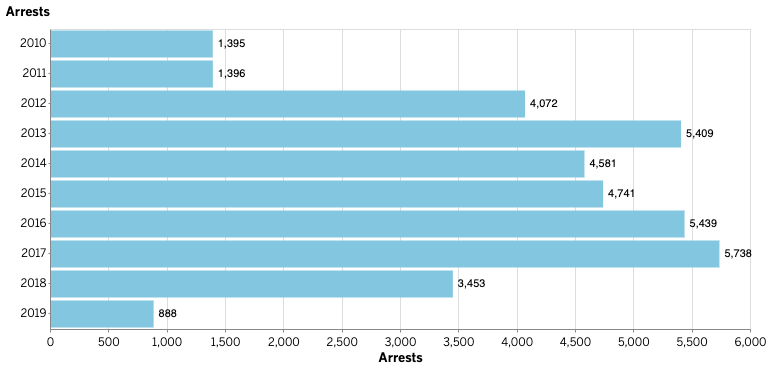

In [37]:
sitlieyears = alt.Chart(sit_lie_years).mark_bar().encode(
    y=alt.Y('year:N', title="Arrests", axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("total:Q", title="Arrests")
)

sitlieyearstext = sitlieyears.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(text=alt.Text('total:Q', format=',')
)

(sitlieyears + sitlieyearstext).properties(height=300, width=700)

### Group all 'sit-lie' cases by charge, location, year — and count arrests

In [38]:
charges_grouped_sit_lie_all = sit_lie_all.groupby\
(['charge', 'charge_description','area_name','reporting_district', 'year'])\
.agg('size').sort_values(ascending=False).reset_index()

In [39]:
charges_grouped_sit_lie_all.columns = ['charge', 'charge_description', 'area_name', 'reporting_district', 'year','total']
charges_grouped_sit_lie_all['reporting_district'] = charges_grouped_sit_lie_all['reporting_district'].astype(str)

In [40]:
charges_grouped_sit_lie_all.head(10)

,charge,charge_description,area_name,reporting_district,year,total
0,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2016,572
1,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,111,2017,427
2,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,158,2013,425
3,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2014,423
4,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2013,388
5,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,111,2016,371
6,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2012,366
7,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,158,2014,339
8,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,138,2017,333
9,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,155,2016,302


In [41]:
districts_counts_years_pivot = pd.pivot_table(charges_grouped_sit_lie_all, values='total', \
index=['reporting_district'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()

### Pivot sit-lie cases by reporting district and year, sorted by 2019

In [42]:
districts_counts_years_pivot.sort_values(by='2019', ascending=False).head(20)

year,reporting_district,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,156,10,39,223,214,150,134,199,317,153,24
1,166,5,39,232,282,196,100,79,189,116,18
2,1307,11,35,93,147,46,44,18,21,17,16
3,176,1,14,52,46,22,65,155,132,71,16
4,157,6,20,372,388,424,304,643,492,89,16
5,171,0,1,0,0,3,11,18,40,30,15
6,165,1,3,34,25,30,16,11,81,46,14
7,566,0,0,0,0,0,1,29,12,57,14
8,155,3,21,140,195,146,162,318,270,63,12
9,138,5,29,177,239,236,295,240,530,116,12


### Export pivot table

In [43]:
districts_counts_years_pivot.to_csv('output/districts_counts_years_pivot.csv')

---

###  Geography

### Import and clean up LAPD reporting districts

In [44]:
reporting_districts_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/lapd_reporting_districts.json')

In [45]:
reporting_districts_src.plot()

In [46]:
reporting_districts_src.columns = reporting_districts_src.columns.str.strip().\
str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [47]:
reporting_districts_src = reporting_districts_src.rename(columns={"repdist": "reporting_district"})

In [48]:
reporting_districts_src['reporting_district'] = reporting_districts_src['reporting_district'].astype(str)

In [49]:
lapd_districts = reporting_districts_src[['reporting_district', 'aprec', 'area', 'geometry']]

---

### Import and clean up LAPD divisions

In [50]:
divisions_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/lapd_divisions.json')

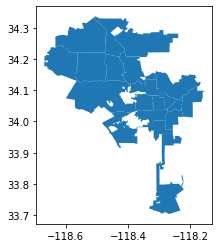

In [51]:
divisions_src.plot()

In [52]:
divisions_src.columns = divisions_src.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [53]:
divisions = divisions_src[['aprec', 'prec', 'area', 'geometry']]

### Import LA Times neighborhoods

In [54]:
hoodssrc = gpd.read_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/input/custom-la-hoods-skid-row.geojson')

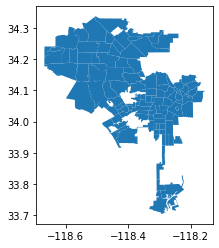

In [55]:
hoodssrc.columns = hoodssrc.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hoodssrc.plot()

### Trim the dataframe

In [56]:
hoods = hoodssrc[['name', 'geometry']]

In [57]:
hoods.head()

,name,geometry
0,Adams-Normandie,(POLYGON ((-118.3090080000001 34.0374109991240...
1,Arleta,(POLYGON ((-118.4220150000001 34.2241029991218...
2,Arlington Heights,"(POLYGON ((-118.315909 34.05261099912384, -118..."
3,Atwater Village,(POLYGON ((-118.2783247308968 34.1530071452962...
4,Baldwin Hills/Crenshaw,(POLYGON ((-118.3562610000001 34.0248359991243...


---

### Relate all 'sit-lie' arrests to LA Times neighborhoods

In [58]:
sit_lie_all_gdf = gpd.GeoDataFrame(sit_lie_all, \
geometry=gpd.points_from_xy(sit_lie_all.longitude, sit_lie_all.latitude))

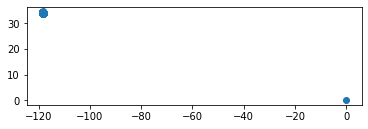

In [59]:
sit_lie_all_gdf.plot()

### Let's remove the stray lat/lon cases

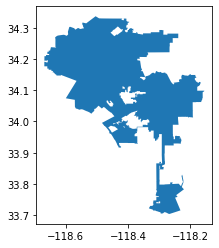

In [60]:
#Read city of Los Angeles boundary file
la = gpd.read_file('input/la_city_boundary/la_city_boundary_1570551157861.geojson')
la.plot()

### Remove stray LA arrests outside city limits by clipping dataframe to city boundary

In [61]:
sit_lie_all_gdf_clipped = cl.clip_shp(sit_lie_all_gdf, la)

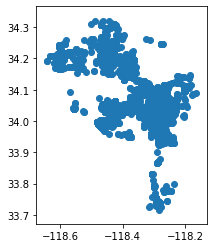

In [62]:
sit_lie_all_gdf_clipped.plot()

### Set coordinate system

In [63]:
sit_lie_all_gdf_clipped.crs = {'init': "epsg:4326"}
sit_lie_all_gdf.crs = {'init': "epsg:4326"}

### Export sit-lie dataframe to geojson file

In [64]:
sit_lie_all_gdf_clipped.to_file('output/sit_lie_all_gdf_clipped.geojson', driver='GeoJSON')

### Hollywood 2019

In [65]:
sit_lie_all_gdf_clipped_2019_hollywood = \
    sit_lie_all_gdf_clipped[(sit_lie_all_gdf_clipped['arrest_date'] > '2019/01/01') \
    & (sit_lie_all_gdf_clipped['area_name'] == 'Hollywood')]

### Citywide 2019

In [66]:
sit_lie_all_gdf_clipped_2019 = sit_lie_all_gdf_clipped[(sit_lie_all_gdf_clipped['arrest_date'] > '2019/01/01')]

### Export CSVs

In [67]:
sit_lie_all_gdf_clipped_2019_hollywood.to_csv('output/sit_lie_all_gdf_clipped_2019_hollywood.csv')
sit_lie_all_gdf_clipped_2019.to_csv('output/sit_lie_all_gdf_clipped_2019.csv')

### Set coordinate system for clipped geodataframe

In [68]:
sit_lie_all_gdf_clipped.crs = {'init': "epsg:4326"}

### Now merge sit-lie geodataframe back to LA Times neighborhoods

In [69]:
sit_lie_all_hoods = gpd.sjoin(sit_lie_all_gdf, hoods, op='within', how="inner")

### 'Busy' neighborhoods: Skid Row, elsewhere Downtown, Venice, Hollywood

In [70]:
busy_hoods = ['Skid Row', 'Downtown', 'Venice', 'Hollywood']

In [71]:
sit_lie_all_hoods['busy'] = sit_lie_all_hoods['name'].isin(busy_hoods)

In [72]:
sit_lie_all_hoods.iloc[10]

report_id                                   191412075
arrest_date                       2019-05-02 00:00:00
time                                             1317
area_id                                            14
area_name                                     Pacific
reporting_district                               1412
age                                                29
sex_code                                            M
descent_code                                        W
charge_group_code                                 nan
charge_group_description                          NaN
arrest_type_code                                    I
charge                                    41.18(D)LAM
charge_description                                NaN
address                                        MARKET
location                           33.9933, -118.4765
year                                             2019
quarter                                             2
day                         

### Trim the dataframe

In [73]:
sit_lie_all_hoods_slim = \
    sit_lie_all_hoods[['report_id','arrest_date','time','area_id',\
                       'area_name','reporting_district','age','sex_code',\
                       'descent_code','charge_group_code','charge_group_description',\
                       'arrest_type_code','charge','charge_description','year',\
                       'month','weekday','name', 'busy']]

### Totals by neighborhood

In [74]:
hood_counts = sit_lie_all_hoods_slim.groupby(['name']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [75]:
#Large neighborhoods
hood_counts_busy = hood_counts[hood_counts['total'] > 200 ].sort_values(by='total', ascending=False)

In [76]:
hood_counts['total'].sum()

36928

In [77]:
hood_counts['share'] = ((hood_counts['total'] / hood_counts['total'].sum())*100).round()
hood_counts.head()

,name,total,share
0,Skid Row,11973,32.0
1,Downtown,7382,20.0
2,Hollywood,5908,16.0
3,Venice,5068,14.0
4,Sawtelle,611,2.0


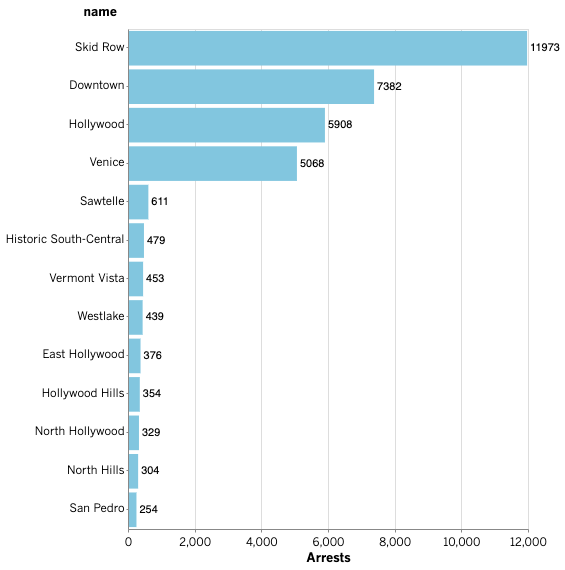

In [78]:
bars = alt.Chart(hood_counts_busy).mark_bar().encode(
    x=alt.X('total:Q', title="Arrests", axis=alt.Axis(format='', tickCount=6)), 
    y=alt.Y(
        'name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            order="descending"  # The order to sort in
        )
    )
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='total:Q'
)
(bars + text).properties(height=500, width=400)

In [79]:
hood_counts_years = sit_lie_all_hoods_slim.groupby(['name', 'year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [80]:
hood_counts_years.head()

,name,year,busy,total
0,Skid Row,2017,True,2225
1,Skid Row,2013,True,2055
2,Skid Row,2016,True,1894
3,Skid Row,2014,True,1853
4,Skid Row,2012,True,1539


### What's the sit-list arrest count in the 'busy' neighborhoods: Skid row, elsewhere Downtown, Venice, Hollywood?

In [81]:
hood_counts_years_grouped = sit_lie_all_hoods_slim.groupby(['year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

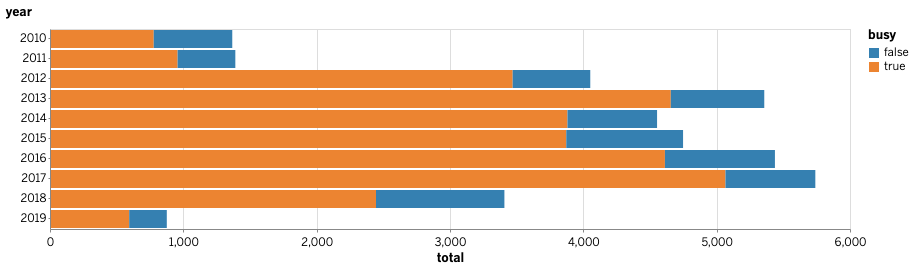

In [82]:
alt.Chart(hood_counts_years_grouped).mark_bar().encode(
    x=alt.X('total', axis=alt.Axis(tickCount=6)),
    y='year',
    color='busy'
)

###  Pivot on arrests by year and neighborhood

In [83]:
hood_counts_years_pivot = pd.pivot_table(hood_counts_years, values='total', index=['name'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()
hood_counts_years_pivot.head(30)

year,name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Venice,93,45,496,857,788,835,704,600,415,235
1,Skid Row,57,220,1539,2055,1853,1332,1894,2225,667,131
2,Downtown,39,132,618,945,780,1170,1401,1520,657,120
3,Hollywood,589,560,817,799,460,535,613,721,706,108
4,Westlake,2,12,38,37,18,17,72,65,118,60
5,Sawtelle,2,4,9,3,12,26,88,169,245,53
6,San Pedro,20,0,0,1,0,9,81,35,91,17
7,Woodland Hills,0,0,2,3,0,1,3,7,10,15
8,East Hollywood,34,37,47,27,23,14,124,24,32,14
9,West Los Angeles,1,0,2,0,0,12,6,45,16,13


###  Filter neighborhoods to the busiest: Skid Row, elsewhere downtown, Hollywood and Venice

In [84]:
hood_counts_years_busy = hood_counts_years[hood_counts_years['busy'] == True]

In [85]:
hood_counts_years_busy.head()

,name,year,busy,total
0,Skid Row,2017,True,2225
1,Skid Row,2013,True,2055
2,Skid Row,2016,True,1894
3,Skid Row,2014,True,1853
4,Skid Row,2012,True,1539


### Arrests by year in Downtown, Hollywood and Venice

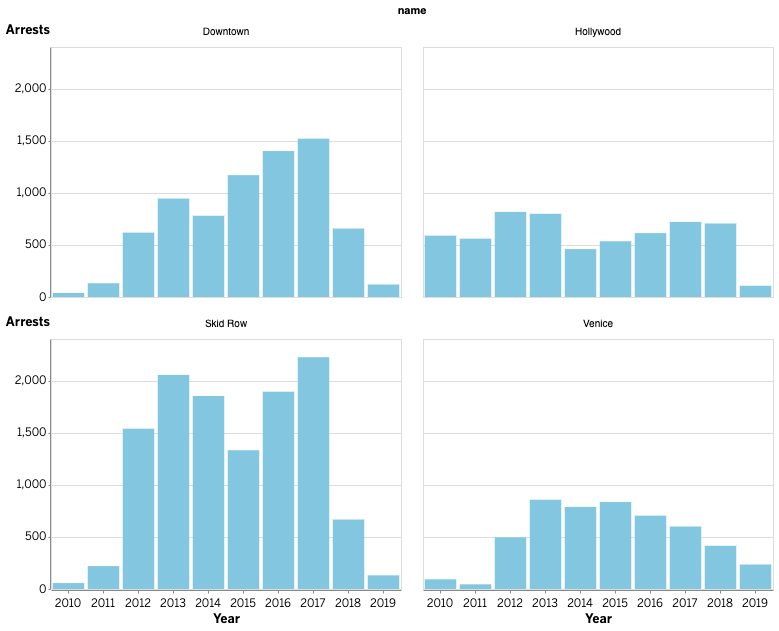

In [86]:
alt.Chart(hood_counts_years_busy).mark_bar().encode(
    y=alt.Y('total:Q', title="Arrests", axis=alt.Axis(format='', tickCount=6),
        sort=alt.EncodingSortField(
            field="year",  # The field to use for the sort
            order="ascending"  # The order to sort in
        )), 
    x=alt.X(
        'year:N', axis=alt.Axis(format='', title='Year')
    ),
    facet='name:O').properties(
    columns=2,
    width=350,
    height=250
)

---

### Merge districts with pivoted arrest totals

In [87]:
districts_counts_years_pivot_geo = lapd_districts.merge(districts_counts_years_pivot, \
    on='reporting_district').sort_values(by='2019', ascending=False)

In [88]:
districts_counts_years_pivot_geo.head()

,reporting_district,aprec,area,geometry,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
72,156,CENTRAL,4.918351e+05,"POLYGON ((-118.245829927991 34.0448847035434, ...",10,39,223,214,150,134,199,317,153,24
77,166,CENTRAL,5.195070e+05,"POLYGON ((-118.247132954996 34.0434723866965, ...",5,39,232,282,196,100,79,189,116,18
75,157,CENTRAL,1.477158e+06,"POLYGON ((-118.2438935457 34.0442013192342, -1...",6,20,372,388,424,304,643,492,89,16
78,176,CENTRAL,2.395319e+06,"POLYGON ((-118.250453124908 34.0432762868349, ...",1,14,52,46,22,65,155,132,71,16
81,1307,NEWTON,7.460919e+06,"POLYGON ((-118.24676663318 34.0407025983443, -...",11,35,93,147,46,44,18,21,17,16


In [89]:
districts_sit_lie_grouped_geo = \
lapd_districts.merge(charges_grouped_sit_lie_all, on='reporting_district').sort_values(by='year', ascending=False)

In [90]:
districts_sit_lie_grouped_geo.head()

,reporting_district,aprec,area,geometry,charge,charge_description,area_name,year,total
0,508,HARBOR,8.990764e+06,"POLYGON ((-118.30892111155 33.8170462789921, -...",41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Harbor,2019,1
2036,426,HOLLENBECK,4.699849e+06,"POLYGON ((-118.172220483 34.088818268669, -118...",41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,Hollenbeck,2019,1
1065,2103,TOPANGA,2.265422e+07,"POLYGON ((-118.605026143263 34.2354547512336, ...",41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,Topanga,2019,2
2013,656,HOLLYWOOD,4.340566e+06,"POLYGON ((-118.333179003278 34.0907396766196, ...",41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Hollywood,2019,1
611,157,CENTRAL,1.477158e+06,"POLYGON ((-118.2438935457 34.0442013192342, -1...",41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,2019,9


### Export to GeoJSON

In [91]:
districts_counts_years_pivot_geo.to_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/districts_counts_years_pivot_geo.json', driver='GeoJSON')

---

###  Mapping

In [92]:
breaks = jenkspy.jenks_breaks(list(districts_sit_lie_grouped_geo.total), nb_class=5)
breaks

[1.0, 19.0, 75.0, 164.0, 302.0, 572.0]

In [93]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [94]:
districts_sit_lie_grouped_geo['arrest_group'] = districts_sit_lie_grouped_geo.total.apply(get_group)

In [95]:
districts_sit_lie_grouped_geo.to_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/districts_sit_lie_grouped_geo.json', driver='GeoJSON')

In [96]:
districts_sit_lie_grouped_geo.head()

,reporting_district,aprec,area,geometry,charge,charge_description,area_name,year,total,arrest_group
0,508,HARBOR,8.990764e+06,"POLYGON ((-118.30892111155 33.8170462789921, -...",41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Harbor,2019,1,0
2036,426,HOLLENBECK,4.699849e+06,"POLYGON ((-118.172220483 34.088818268669, -118...",41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,Hollenbeck,2019,1,0
1065,2103,TOPANGA,2.265422e+07,"POLYGON ((-118.605026143263 34.2354547512336, ...",41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,Topanga,2019,2,0
2013,656,HOLLYWOOD,4.340566e+06,"POLYGON ((-118.333179003278 34.0907396766196, ...",41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Hollywood,2019,1,0
611,157,CENTRAL,1.477158e+06,"POLYGON ((-118.2438935457 34.0442013192342, -1...",41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,2019,9,0


In [97]:
sit_lie_geojson = json.loads(districts_sit_lie_grouped_geo.to_json())
sit_lie_features = alt.Data(values=sit_lie_geojson['features'])

In [98]:
districts_geojson = json.loads(lapd_districts.to_json())
districts_features = alt.Data(values=districts_geojson['features'])

In [99]:
hoods_geojson = json.loads(hoods.to_json())
hoods_features = alt.Data(values=hoods_geojson['features'])

In [100]:
districts_geojson_pivot = json.loads(districts_counts_years_pivot_geo.to_json())
districts_geojson_pivot_features = alt.Data(values=districts_geojson_pivot['features'])

In [101]:
# basemap = alt.Chart(districts_features).mark_geoshape(
#     fill='lightgray',
#     stroke=''
# ).project('mercator')

# groups = alt.Chart(sit_lie_features).mark_geoshape(
#     stroke='white'
# ).encode(
#     color='properties.arrest_group:Q'
# ).transform_filter(
#     alt.FieldEqualPredicate(field='properties.year', equal='2016')
# )

# hoodsmaps = alt.Chart(hoods_features).mark_geoshape(
#     fill='',
#     stroke='#999999',
#     strokeWidth=.2
# )

# (basemap+groups+hoodsmaps).properties(
#     width=600,
#     height=600
# )

In [102]:
# variable_list = ['properties.2010','properties.2011','properties.2012','properties.2013','properties.2014','properties.2015','properties.2016','properties.2017','properties.2018','properties.2019']

In [103]:
# alt.Chart(districts_features).mark_geoshape().encode(
#     alt.Color(alt.repeat('row'), type='quantitative')
# ).transform_lookup(
#     lookup='properties.reporting_district',
#     from_=alt.LookupData(districts_geojson_pivot_features, 'properties.reporting_district', variable_list)
# ).properties(
#     width=500,
#     height=500
# ).repeat(
#     row=variable_list
# ).resolve_scale(
#     color='shared'
# )

### Group all 'sit-lie' cases by place and time

In [104]:
time_sit_lie_hoods = \
    sit_lie_all_hoods.groupby(['name', 'year', 'hour', 'night']).agg('size')\
    .sort_values(ascending=False).reset_index()

In [105]:
time_sit_lie_hoods.columns = ['name', 'year','hour', 'night', 'total']

In [106]:
time_sit_lie_hoods.head()

,name,year,hour,night,total
0,Skid Row,2014,07,False,728
1,Skid Row,2013,07,False,623
2,Skid Row,2016,08,False,461
3,Skid Row,2012,07,False,402
4,Skid Row,2013,08,False,356


In [107]:
time_sit_lie_hoods_busy = time_sit_lie_hoods[time_sit_lie_hoods['name'].isin(busy_hoods)]

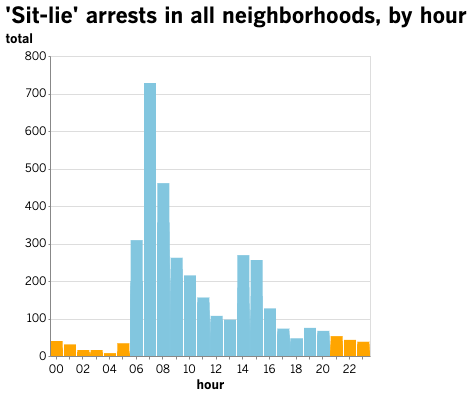

In [108]:
alt.Chart(time_sit_lie_hoods).mark_bar().encode(
    x='hour:O',
    y="total:Q",
    color=alt.condition(
        alt.datum.night == True,
        alt.value('orange'), 
        alt.value('#82c6df')
    )
).properties(
    title='\'Sit-lie\' arrests in all neighborhoods, by hour',
    columns=2,
    width=320,
    height=300
)

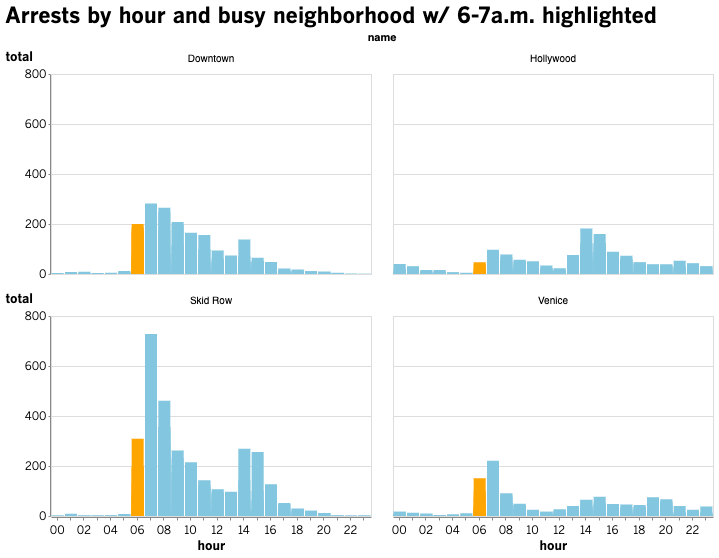

In [109]:
alt.Chart(time_sit_lie_hoods_busy).mark_bar().encode(
    x='hour:O',
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='name:O'
).properties(
    title='Arrests by hour and busy neighborhood w/ 6-7a.m. highlighted',
    columns=2,
    width=320,
    height=200
)

### How many 'sit-lit' arrests happen between 9-6 a.m.?

In [110]:
time_sit_lie_hoods_busy['night'].value_counts('normalize').round(2)

False    0.71
True     0.29
Name: night, dtype: float64

In [111]:
time_sit_lie_hoods_busy_grouped = time_sit_lie_hoods_busy.groupby(['year', 'night']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [112]:
time_sit_lie_hoods_busy_grouped.head()

,year,night,total
0,2013,False,60
1,2012,False,60
2,2016,False,60
3,2018,False,59
4,2017,False,59


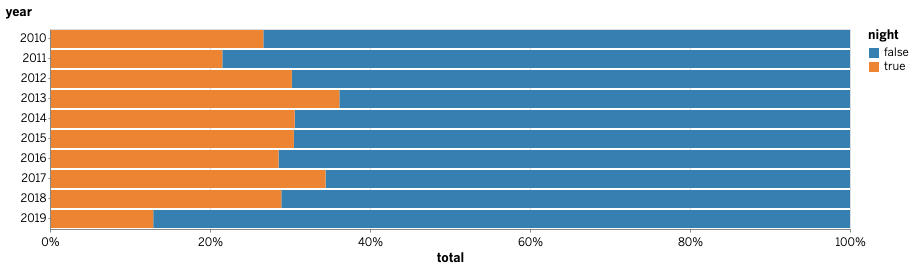

In [113]:
alt.Chart(time_sit_lie_hoods_busy_grouped).mark_bar().encode(
    x=alt.X('total:Q', stack="normalize", axis=alt.Axis(format='%',tickCount=6)),
    y='year:N',
    color='night'
)

### What is the average number of arrests per month — and how has that changed over the years? 

In [114]:
sit_lie_all_hoods.columns

Index(['report_id', 'arrest_date', 'time', 'area_id', 'area_name',
       'reporting_district', 'age', 'sex_code', 'descent_code',
       'charge_group_code', 'charge_group_description', 'arrest_type_code',
       'charge', 'charge_description', 'address', 'location', 'year',
       'quarter', 'day', 'month', 'monthname', 'weekday', 'hour', 'minute',
       'night', 'latitude', 'longitude', 'descent_description',
       'arrest_type_description', 'geometry', 'index_right', 'name', 'busy'],
      dtype='object')

### Groupby neighborhood and dates — all hoods

In [115]:
months_grouped = sit_lie_all_hoods.groupby(['name', 'monthname', 'year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

### Groupby neighborhood and dates — busy hoods

In [116]:
months_grouped_busy = sit_lie_all_hoods[sit_lie_all_hoods['busy'] == True].groupby(['name', 'monthname']).agg('size').sort_values(ascending=False).reset_index(name='total')

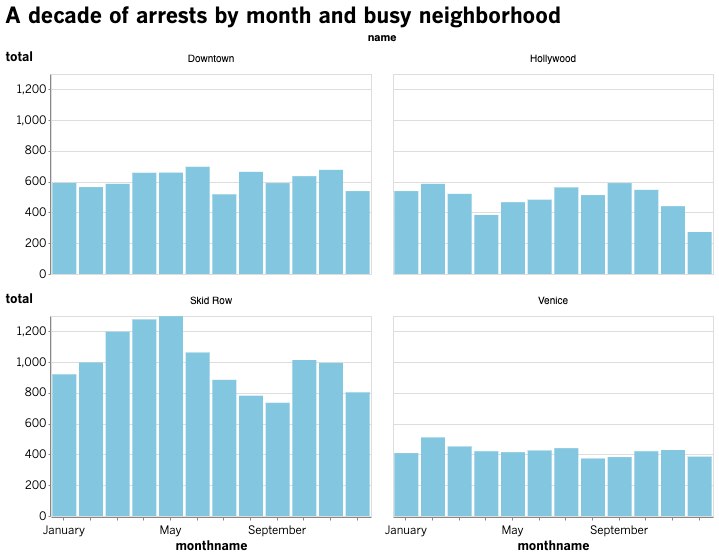

In [117]:
alt.Chart(months_grouped_busy).mark_bar().encode(
    x=alt.X('monthname:O', sort=['January','February','March','April','May','June','July','August','September','October','November','December']),
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='name:O'
).properties(
    title='A decade of arrests by month and busy neighborhood',
    columns=2,
    width=320,
    height=200
)

### # What's going on in Skid Row?

In [118]:
skidrow_months_grouped_busy = sit_lie_all_hoods[sit_lie_all_hoods['name'] == 'Skid Row'].groupby(['name', 'year','monthname']).agg('size').sort_values(ascending=False).reset_index(name='total')

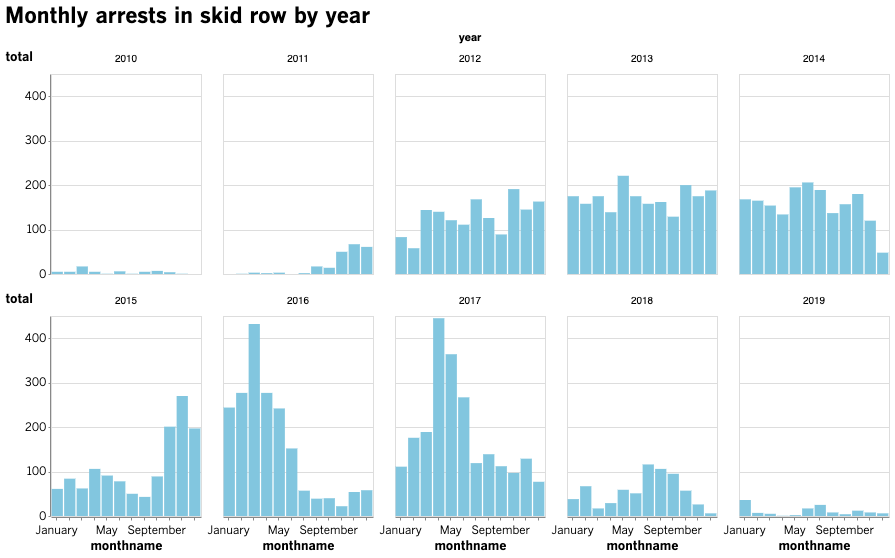

In [119]:
alt.Chart(skidrow_months_grouped_busy).mark_bar().encode(
    x=alt.X('monthname:O', sort=['January','February','March','April','May','June','July','August','September','October','November','December']),
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='year:O'
).properties(
    title='Monthly arrests in skid row by year',
    columns=5,
    width=150,
    height=200
)

### # 'Sit-lie' arrests by day

In [120]:
sit_lie_all_dates = sit_lie_all.groupby(['arrest_date', 'year', 'weekday']).agg('size').reset_index(name='total')

In [121]:
###  One of busiest days 
sit_lie_all_one_day = sit_lie_all[sit_lie_all['arrest_date'] == '2018-05-30']
sit_lie_all_one_day.sort_values(by='time', ascending=True).head(5)

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,quarter,day,month,monthname,weekday,hour,minute,night,latitude,longitude,descent_description,arrest_type_description,geometry
453126,180613143,2018-05-30,0230,6,Hollywood,646,49,M,W,nan,NaN,M,41.18(D)LAM,NaN,SELMA,"34.0997, -118.3361",2018,2,30,5,May,Wednesday,02,30,True,34.0997,-118.3361,White,Misdemeanor,POINT (-118.3361 34.0997)
451615,180613142,2018-05-30,0310,6,Hollywood,644,44,M,W,nan,NaN,M,41.18(D)LAM,NaN,DETROIT,"34.098, -118.3452",2018,2,30,5,May,Wednesday,03,10,True,34.0980,-118.3452,White,Misdemeanor,POINT (-118.3452 34.098)
452672,180613147,2018-05-30,0315,6,Hollywood,666,64,F,W,nan,NaN,M,41.18(D)LAM,NaN,LELAND WY,"34.0971, -118.3267",2018,2,30,5,May,Wednesday,03,15,True,34.0971,-118.3267,White,Misdemeanor,POINT (-118.3267 34.0971)
452018,180613146,2018-05-30,0330,6,Hollywood,644,39,F,B,nan,NaN,I,41.18(D)LAM,NaN,FORMOSA,"34.098, -118.3463",2018,2,30,5,May,Wednesday,03,30,True,34.0980,-118.3463,Black,Infraction,POINT (-118.3463 34.098)
451622,180613191,2018-05-30,0440,6,Hollywood,637,33,M,B,nan,NaN,I,41.18(D)LAM,NaN,GOWER,"34.1043, -118.3224",2018,2,30,5,May,Wednesday,04,40,True,34.1043,-118.3224,Black,Infraction,POINT (-118.3224 34.1043)


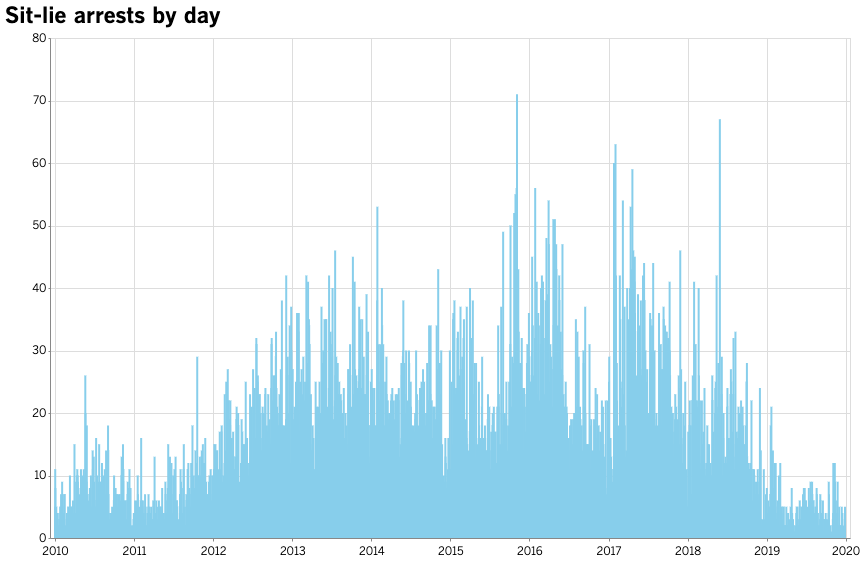

In [122]:
alt.Chart(sit_lie_all_dates).mark_bar(size=2).encode(
    x=alt.X('arrest_date:T', axis=alt.Axis(format='%Y', title='', tickCount = 10)),
    y=alt.X('sum(total):Q', axis=alt.Axis(format='', title='', tickCount = 10)),
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.arrest_date == '2018-09-04',  # If the year is 1810 this test returns True,
        alt.value('#000000'),     # which sets the bar orange.
        alt.value('skyblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(title='Sit-lie arrests by day', width=800, height=500)


In [123]:
sit_lie_all_dates.sort_values(by='arrest_date', ascending=False).head(100)

,arrest_date,year,weekday,total
3328,2019-12-29,2019,Sunday,5
3327,2019-12-28,2019,Saturday,3
3326,2019-12-26,2019,Thursday,1
3325,2019-12-22,2019,Sunday,1
3324,2019-12-20,2019,Friday,2
3323,2019-12-17,2019,Tuesday,4
3322,2019-12-16,2019,Monday,1
3321,2019-12-14,2019,Saturday,5
3320,2019-12-13,2019,Friday,2
3319,2019-12-11,2019,Wednesday,2


In [124]:
sit_lie_all_dates.to_csv('output/sit_lie_all_dates.csv')

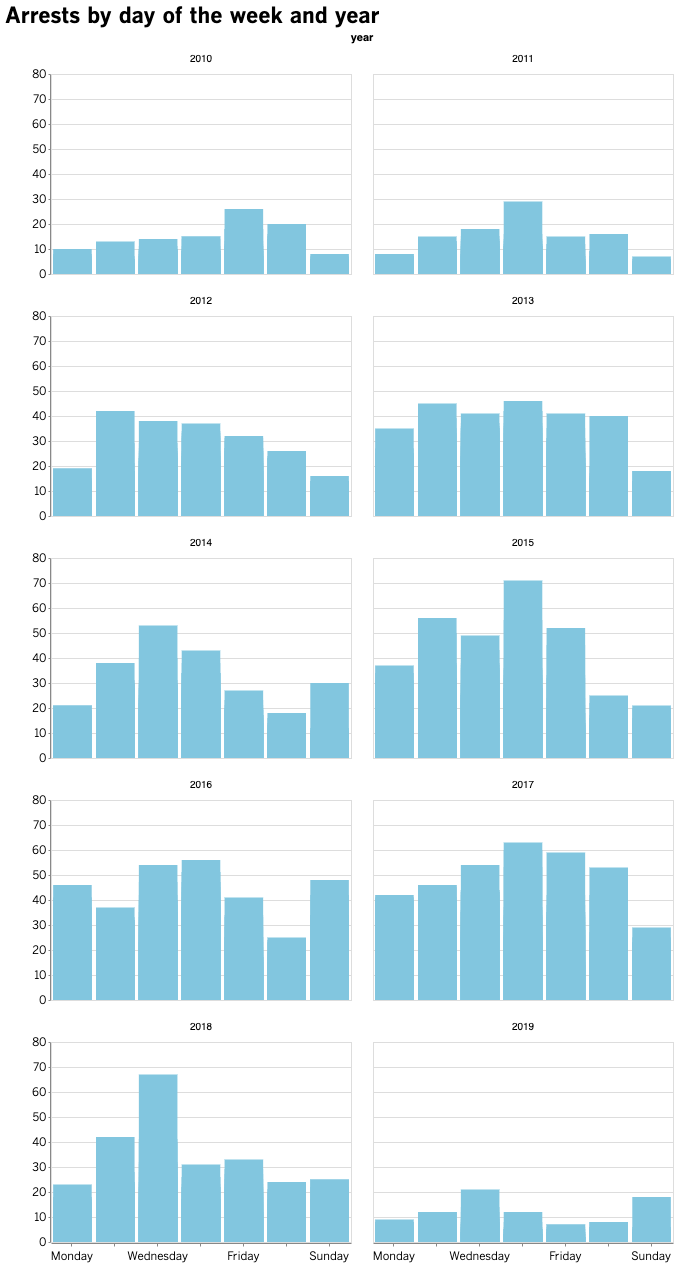

In [125]:
alt.Chart(sit_lie_all_dates).mark_bar().encode(
    x=alt.X('weekday:O', axis=alt.Axis(title='', tickCount = 10), 
            sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y=alt.X('total:Q', axis=alt.Axis(title='', tickCount = 10)
),
    facet='year:O'
).properties(
    title='Arrests by day of the week and year',
    columns=2,
    width=300,
    height=200
)

---

###  Homeless population estimates by LA Times neighborhoods

In [126]:
homelessbyhood = pd.read_csv('input/homeless-unsheltered-by-hood.csv')

In [127]:
homelessbyhood.head()

,name,unsheltered,unshelteredoutside
0,Downtown,2477.656050,2298.862691
1,Skid Row,1560.699515,1511.234336
2,Westlake,1239.655588,921.219987
3,Historic South-Central,944.710611,673.731808
4,Hollywood,1191.539096,634.890246


### Merge with previously pivoted arrests data with hoods spatial data — then merge population counts

In [128]:
hood_counts_years.head()

,name,year,busy,total
0,Skid Row,2017,True,2225
1,Skid Row,2013,True,2055
2,Skid Row,2016,True,1894
3,Skid Row,2014,True,1853
4,Skid Row,2012,True,1539


In [129]:
hoods_counts_years_pivot_geo = hoods.merge(hood_counts_years_pivot, on='name').sort_values(by='2019', ascending=False)

In [130]:
hoods_homeless_counts_years_pivot_geo = hoods_counts_years_pivot_geo.merge(homelessbyhood, on='name').sort_values(by='2019', ascending=False)

In [131]:
hoods_homeless_counts_years_pivot_geo.head(10)

,name,geometry,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,unsheltered,unshelteredoutside
0,Venice,(POLYGON ((-118.4518110000002 33.9645109991250...,93,45,496,857,788,835,704,600,415,235,1091.534800,567.493195
1,Skid Row,"(POLYGON ((-118.2381244 34.04325639999996, -11...",57,220,1539,2055,1853,1332,1894,2225,667,131,1560.699515,1511.234336
2,Downtown,POLYGON ((-118.2402070000001 34.05871099912385...,39,132,618,945,780,1170,1401,1520,657,120,2477.656050,2298.862691
3,Hollywood,"(POLYGON ((-118.32691 34.10520799999951, -118....",589,560,817,799,460,535,613,721,706,108,1191.539096,634.890246
4,Westlake,"(POLYGON ((-118.280308 34.07690999912365, -118...",2,12,38,37,18,17,72,65,118,60,1239.655588,921.219987
5,Sawtelle,"(POLYGON ((-118.443912 34.04720899912407, -118...",2,4,9,3,12,26,88,169,245,53,267.711848,147.920090
6,San Pedro,"(POLYGON ((-118.243705 33.76171699912748, -118...",20,0,0,1,0,9,81,35,91,17,533.744600,247.848572
7,Woodland Hills,"(POLYGON ((-118.57569 34.18822399912241, -118....",0,0,2,3,0,1,3,7,10,15,111.568570,45.983859
8,East Hollywood,"(POLYGON ((-118.293009 34.10170899912326, -118...",34,37,47,27,23,14,124,24,32,14,528.656377,362.502867
9,West Los Angeles,"(POLYGON ((-118.434212 34.03730999912411, -118...",1,0,2,0,0,12,6,45,16,13,76.449771,51.631183


### Loop and create rate columns for each year

In [132]:
# hoods_homeless_counts_years_pivot_geo['2017-rate'] = (hoods_homeless_counts_years_pivot_geo['2017']/hoods_homeless_counts_years_pivot_geo['unsheltered'])*100

for n in range(2010, 2020):
    hoods_homeless_counts_years_pivot_geo[f'{n}_rate'] = (hoods_homeless_counts_years_pivot_geo[f'{n}']/hoods_homeless_counts_years_pivot_geo['unsheltered'])*100


In [133]:
hoods_homeless_counts_years_pivot_geo.head()

,name,geometry,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,unsheltered,unshelteredoutside,2010_rate,2011_rate,2012_rate,2013_rate,2014_rate,2015_rate,2016_rate,2017_rate,2018_rate,2019_rate
0,Venice,(POLYGON ((-118.4518110000002 33.9645109991250...,93,45,496,857,788,835,704,600,415,235,1091.534800,567.493195,8.520113,4.122635,45.440603,78.513301,72.191926,76.497790,64.496340,54.968472,38.019860,21.529318
1,Skid Row,"(POLYGON ((-118.2381244 34.04325639999996, -11...",57,220,1539,2055,1853,1332,1894,2225,667,131,1560.699515,1511.234336,3.652208,14.096243,98.609629,131.671727,118.728812,85.346345,121.355840,142.564278,42.737247,8.393672
2,Downtown,POLYGON ((-118.2402070000001 34.05871099912385...,39,132,618,945,780,1170,1401,1520,657,120,2477.656050,2298.862691,1.574068,5.327616,24.942929,38.140887,31.481367,47.222051,56.545379,61.348305,26.516998,4.843287
3,Hollywood,"(POLYGON ((-118.32691 34.10520799999951, -118....",589,560,817,799,460,535,613,721,706,108,1191.539096,634.890246,49.431865,46.998038,68.566781,67.056130,38.605531,44.899912,51.446067,60.509974,59.251098,9.063907
4,Westlake,"(POLYGON ((-118.280308 34.07690999912365, -118...",2,12,38,37,18,17,72,65,118,60,1239.655588,921.219987,0.161335,0.968011,3.065368,2.984700,1.452016,1.371349,5.808065,5.243392,9.518773,4.840054


### Export GeoJSON

In [134]:
hoods_homeless_counts_years_pivot_geo.to_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/hoods_homeless_counts_years_pivot_geo.json', driver='GeoJSON')

In [135]:
hoods_homeless_counts_years_pivot_geo.to_csv('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/hoods_homeless_counts_years_pivot_geo.csv')

In [136]:
hood_counts_years_pivot = pd.pivot_table(hood_counts_years, \
    values='total', index=['name'], columns=['year'], \
    aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()

In [137]:
hood_counts_years_pivot.head(10)

year,name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Venice,93,45,496,857,788,835,704,600,415,235
1,Skid Row,57,220,1539,2055,1853,1332,1894,2225,667,131
2,Downtown,39,132,618,945,780,1170,1401,1520,657,120
3,Hollywood,589,560,817,799,460,535,613,721,706,108
4,Westlake,2,12,38,37,18,17,72,65,118,60
5,Sawtelle,2,4,9,3,12,26,88,169,245,53
6,San Pedro,20,0,0,1,0,9,81,35,91,17
7,Woodland Hills,0,0,2,3,0,1,3,7,10,15
8,East Hollywood,34,37,47,27,23,14,124,24,32,14
9,West Los Angeles,1,0,2,0,0,12,6,45,16,13


In [138]:
hood_counts_years_pivot.to_csv('output/hood_counts_years_pivot.csv')

In [139]:
hood_counts_years_busy = hood_counts_years[(hood_counts_years['busy'] == True) &\
                                           (hood_counts_years['year'] != '2020')]

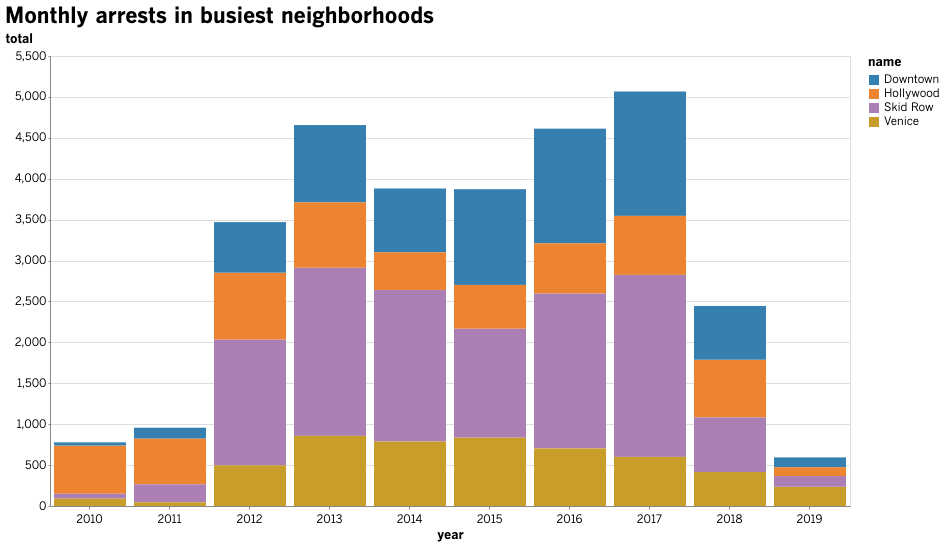

In [140]:
alt.Chart(hood_counts_years_busy).mark_bar().encode(
    x='year:N',
    y='total:Q',
    color='name'
).properties(width=800,title='Monthly arrests in busiest neighborhoods',)

---